In [1]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load Dataset

In [2]:
# Paths to the dataset
base_folder = 'dataset'
train_folder = os.path.join(base_folder, 'train')
test_folder = os.path.join(base_folder, 'test')
train_labels_file = os.path.join(base_folder, 'trainLabels.csv')
submission_file = os.path.join(base_folder, 'sampleSubmission.csv')

In [5]:
# Image properties
image_size = (32, 32)

# Load train labels
train_labels_df = pd.read_csv(train_labels_file)
train_labels = train_labels_df.set_index('id')['label'].to_dict()  # Create a dictionary {id: label}

unique_labels = train_labels_df['label'].unique()
label_mapping = {label: idx for idx, label in enumerate(unique_labels)}

#print("Label Mapping:", label_mapping)  # Verify the mapping

train_labels_df['label'] = train_labels_df['label'].map(label_mapping)
train_labels = train_labels_df.set_index('id')['label'].to_dict()  # {id: integer_label}

# Debugging: Check the first few labels
#print(train_labels_df.head())

# Batch generator for training images
def train_batch_generator(batch_size):
    image_names = os.listdir(train_folder)
    while True:
        for i in range(0, len(image_names), batch_size):
            batch_images = image_names[i:i + batch_size]
            X_batch = []
            Y_batch = []
            for img_name in batch_images:
                img_id = os.path.splitext(img_name)[0]
                if img_id.isdigit() and int(img_id) in train_labels:
                    img_path = os.path.join(train_folder, img_name)
                    img = load_img(img_path, target_size=image_size)
                    img_array = img_to_array(img)
                    X_batch.append(img_array)
                    Y_batch.append(train_labels[int(img_id)])  # Integer labels
            X_batch = np.array(X_batch) / 255.0  # Normalize images
            Y_batch = np.array(Y_batch)  # Keep labels as integers
            yield X_batch, Y_batch

# Batch generator for testing images
def test_batch_generator(batch_size):
    test_ids = os.listdir(test_folder)  # List all test image files
    while True:
        for i in range(0, len(test_ids), batch_size):
            batch_images = test_ids[i:i + batch_size]
            X_batch = []
            for img_name in batch_images:
                img_path = os.path.join(test_folder, img_name)
                if os.path.exists(img_path):
                    img = load_img(img_path, target_size=image_size)
                    img_array = img_to_array(img)
                    X_batch.append(img_array)
            if len(X_batch) > 0:
                yield np.array(X_batch) / 255.0  # Normalize images

# Example usage of generators
batch_size = 128
train_gen = train_batch_generator(batch_size)
#test_gen = test_batch_generator(batch_size)

# Debug the generator
train_gen = train_batch_generator(batch_size)
X_train, Y_train = next(train_gen)
print(f"X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}")
#print(f"First few labels: {Y_train[:10]}")

# Output shapes
#print(f'X_train shape: {X_train.shape}')
#print(f'Y_train shape: {Y_train.shape}')
#print(f'X_test shape: {X_test.shape}')


X_train shape: (128, 32, 32, 3), Y_train shape: (128,)


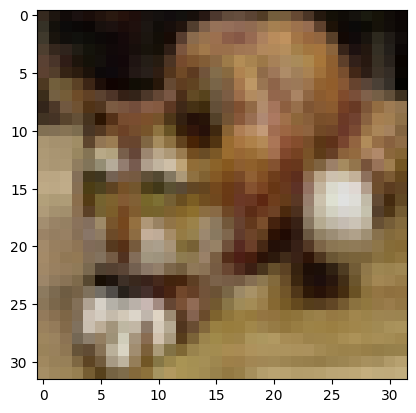

In [6]:
idx = random.randint(0, len(X_train))
plt.imshow(X_train[idx, :])
plt.show()

# Model

In [7]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(len(label_mapping), activation='softmax')  # Output layer for multi-class classification
])

#from tensorflow.keras.layers import Dropout

#model.add(Dense(64, activation='relu'))
#model.add(Dropout(0.5))  # Dropout rate of 50%
#model.add(Dense(10, activation='softmax'))

#from tensorflow.keras.regularizers import l2

#model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))


C:\Users\y_maa\miniconda3\envs\ai_project4\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
model = Sequential()

model.add(Conv2D(32, (3,3), activation = 'relu', input_shape = (32, 32, 3)))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(32, (3,3), activation = 'relu'))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())
model.add(Dense(64, activation = 'relu'))
model.add(Dense(10, activation = 'softmax'))

In [10]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
X_train, Y_train = next(train_gen)
print(f"Labels in Y_train: {Y_train[:5]}")  # Should now contain integers
print(f"Labels dtype: {Y_train.dtype}")  # Ensure labels are int32

Labels in Y_train: [0 3 0 5 9]
Labels dtype: int64


# Train the Model

In [11]:
# Train the model
steps_per_epoch = len(os.listdir(train_folder)) // batch_size
model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs = 5
)

Epoch 1/5
390/390 ━━━━━━━━━━━━━━━━━━━━ 60s 153ms/step - accuracy: 0.3276 - loss: 1.8433
Epoch 2/5
390/390 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.5234 - loss: 1.3515
Epoch 3/5
390/390 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.5729 - loss: 1.2207
Epoch 4/5
390/390 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.6040 - loss: 1.1386
Epoch 5/5
390/390 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.6261 - loss: 1.0750 


In [9]:
# Save Model

In [12]:
model.save("trained_model.h5")  # Save to a single file

In [ ]:
# Load Model

In [9]:
from tensorflow.keras.models import load_model
model = load_model("trained_model.h5")

C:\Users\y_maa\miniconda3\envs\ai_project4\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [13]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 13, 13, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 6, 6, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 253,760 (991.25 KB)

 Trainable params: 84,586 (330.41 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 169,174 (660.84 KB)

# Making predictions

In [14]:
# Initialize test generator and steps
batch_size = 128
test_steps = len(os.listdir(test_folder)) // batch_size
test_gen = test_batch_generator(batch_size)

# Predict the labels for the test set
predictions = model.predict(test_gen, steps=test_steps)

# Map predictions to class indices
predicted_classes = np.argmax(predictions, axis=1)  # Convert probabilities to class indices


# Reverse the label mapping
reverse_mapping = {v: k for k, v in label_mapping.items()}

# Convert predicted classes to labels
predicted_labels = [reverse_mapping[idx] for idx in predicted_classes]


ValueError: When passing a Python generator to a Keras model, the generator must return a tuple, either (input,) or (inputs, targets) or (inputs, targets, sample_weights). Received: [[[[0.5254902  0.45490196 0.30588236]
   [0.5647059  0.49803922 0.35686275]
   [0.5686275  0.5019608  0.36078432]
   ...
   [0.50980395 0.42745098 0.28235295]
   [0.50980395 0.43137255 0.3019608 ]
   [0.49019608 0.41960785 0.29803923]]

  [[0.5568628  0.49019608 0.34117648]
   [0.57254905 0.5137255  0.37254903]
   [0.5764706  0.5254902  0.3882353 ]
   ...
   [0.54509807 0.44313726 0.28627452]
   [0.5529412  0.46666667 0.32156864]
   [0.52156866 0.4392157  0.3137255 ]]

  [[0.56078434 0.5176471  0.34117648]
   [0.6        0.57254905 0.35686275]
   [0.5882353  0.57254905 0.3647059 ]
   ...
   [0.5568628  0.4627451  0.30588236]
   [0.5411765  0.45490196 0.3137255 ]
   [0.5254902  0.4509804  0.32941177]]

  ...

  [[0.56078434 0.5058824  0.49019608]
   [0.6039216  0.4392157  0.40784314]
   [0.62352943 0.5058824  0.4745098 ]
   ...
   [0.47058824 0.5372549  0.35686275]
   [0.49803922 0.5294118  0.3529412 ]
   [0.54509807 0.5764706  0.28235295]]

  [[0.5019608  0.5882353  0.5686275 ]
   [0.5176471  0.53333336 0.47058824]
   [0.5058824  0.5921569  0.54509807]
   ...
   [0.49803922 0.5176471  0.32941177]
   [0.5254902  0.56078434 0.24705882]
   [0.4509804  0.49803922 0.21960784]]

  [[0.32156864 0.5921569  0.5254902 ]
   [0.28627452 0.50980395 0.39607844]
   [0.3019608  0.5019608  0.40784314]
   ...
   [0.49803922 0.5254902  0.27450982]
   [0.38431373 0.42352942 0.21176471]
   [0.25882354 0.3019608  0.20392157]]]


 [[[0.50980395 0.46666667 0.54509807]
   [0.5137255  0.46666667 0.54901963]
   [0.5176471  0.47058824 0.5568628 ]
   ...
   [0.54901963 0.4862745  0.5764706 ]
   [0.54901963 0.48235294 0.57254905]
   [0.49411765 0.45490196 0.5254902 ]]

  [[0.5647059  0.49019608 0.5882353 ]
   [0.58431375 0.5058824  0.59607846]
   [0.6117647  0.5294118  0.6156863 ]
   ...
   [0.54901963 0.48235294 0.57254905]
   [0.54901963 0.48235294 0.5686275 ]
   [0.5019608  0.45882353 0.5254902 ]]

  [[0.5686275  0.49019608 0.5882353 ]
   [0.6039216  0.5176471  0.59607846]
   [0.68235296 0.5803922  0.6392157 ]
   ...
   [0.5529412  0.4862745  0.5686275 ]
   [0.5529412  0.48235294 0.5686275 ]
   [0.50980395 0.45882353 0.5254902 ]]

  ...

  [[0.32156864 0.3254902  0.32156864]
   [0.34509805 0.30588236 0.34901962]
   [0.2627451  0.21568628 0.2901961 ]
   ...
   [0.34117648 0.3019608  0.2901961 ]
   [0.34509805 0.3019608  0.29803923]
   [0.34901962 0.30588236 0.3019608 ]]

  [[0.2784314  0.2901961  0.28627452]
   [0.31764707 0.28627452 0.32156864]
   [0.26666668 0.21176471 0.28627452]
   ...
   [0.35686275 0.32941177 0.32941177]
   [0.36078432 0.32941177 0.34117648]
   [0.36078432 0.32941177 0.3372549 ]]

  [[0.2509804  0.26666668 0.2627451 ]
   [0.30588236 0.2784314  0.30980393]
   [0.26666668 0.21960784 0.2901961 ]
   ...
   [0.3137255  0.30980393 0.30588236]
   [0.30980393 0.30588236 0.30980393]
   [0.30588236 0.3019608  0.3019608 ]]]


 [[[0.5019608  0.5411765  0.30980393]
   [0.42745098 0.47843137 0.2627451 ]
   [0.40784314 0.48235294 0.25882354]
   ...
   [0.49411765 0.5294118  0.29803923]
   [0.5372549  0.56078434 0.3372549 ]
   [0.5176471  0.53333336 0.32156864]]

  [[0.49019608 0.5411765  0.27450982]
   [0.4627451  0.5058824  0.23921569]
   [0.44313726 0.5137255  0.27058825]
   ...
   [0.50980395 0.5176471  0.29411766]
   [0.5529412  0.5411765  0.32941177]
   [0.6039216  0.5764706  0.36862746]]

  [[0.42352942 0.5058824  0.20392157]
   [0.47843137 0.5294118  0.24705882]
   [0.44705883 0.5058824  0.27058825]
   ...
   [0.54509807 0.5411765  0.32941177]
   [0.59607846 0.56078434 0.3647059 ]
   [0.627451   0.5921569  0.38039216]]

  ...

  [[0.3882353  0.45882353 0.23137255]
   [0.36862746 0.43529412 0.21176471]
   [0.47058824 0.5137255  0.27450982]
   ...
   [0.46666667 0.5176471  0.28235295]
   [0.49803922 0.5294118  0.2901961 ]
   [0.53333336 0.54509807 0.3254902 ]]

  [[0.4392157  0.5019608  0.2627451 ]
   [0.43529412 0.50980395 0.2509804 ]
   [0.5294118  0.5882353  0.2901961 ]
   ...
   [0.49803922 0.5137255  0.2901961 ]
   [0.4862745  0.49411765 0.3019608 ]
   [0.49411765 0.4862745  0.28627452]]

  [[0.5137255  0.5882353  0.3137255 ]
   [0.4509804  0.5411765  0.2627451 ]
   [0.45490196 0.5411765  0.22745098]
   ...
   [0.5411765  0.53333336 0.3137255 ]
   [0.4862745  0.4745098  0.2901961 ]
   [0.45490196 0.4745098  0.2627451 ]]]


 ...


 [[[0.19215687 0.14901961 0.1254902 ]
   [0.20392157 0.16078432 0.12156863]
   [0.29411766 0.23529412 0.14901961]
   ...
   [0.60784316 0.4509804  0.5058824 ]
   [0.62352943 0.46666667 0.52156866]
   [0.6392157  0.5137255  0.5529412 ]]

  [[0.2        0.16862746 0.13333334]
   [0.20392157 0.18039216 0.13725491]
   [0.28235295 0.24705882 0.16862746]
   ...
   [0.6039216  0.45882353 0.4862745 ]
   [0.61960787 0.47843137 0.5058824 ]
   [0.62352943 0.5058824  0.5176471 ]]

  [[0.19215687 0.16862746 0.13333334]
   [0.21176471 0.2        0.17254902]
   [0.30588236 0.2784314  0.24313726]
   ...
   [0.5803922  0.47058824 0.45882353]
   [0.5686275  0.45490196 0.44705883]
   [0.50980395 0.41568628 0.39215687]]

  ...

  [[0.4627451  0.3647059  0.21960784]
   [0.50980395 0.38039216 0.2901961 ]
   [0.5372549  0.3882353  0.28235295]
   ...
   [0.38431373 0.28627452 0.23921569]
   [0.34901962 0.27058825 0.2       ]
   [0.30980393 0.24705882 0.17254902]]

  [[0.45882353 0.38039216 0.22745098]
   [0.49803922 0.38431373 0.28627452]
   [0.54509807 0.4117647  0.29411766]
   ...
   [0.24313726 0.19215687 0.15686275]
   [0.21568628 0.19607843 0.12941177]
   [0.1764706  0.16470589 0.10588235]]

  [[0.43529412 0.3764706  0.22352941]
   [0.49019608 0.4        0.28235295]
   [0.5294118  0.41960785 0.27450982]
   ...
   [0.23921569 0.20784314 0.17254902]
   [0.21960784 0.23529412 0.16470589]
   [0.16078432 0.17254902 0.11764706]]]


 [[[0.5921569  0.5254902  0.41568628]
   [0.61960787 0.5568628  0.5254902 ]
   [0.67058825 0.45882353 0.49019608]
   ...
   [0.6627451  0.47058824 0.4117647 ]
   [0.67058825 0.5803922  0.43529412]
   [0.61960787 0.49411765 0.40392157]]

  [[0.69411767 0.41568628 0.40392157]
   [0.6392157  0.54901963 0.5058824 ]
   [0.6392157  0.52156866 0.3764706 ]
   ...
   [0.62352943 0.44313726 0.36862746]
   [0.6784314  0.52156866 0.44313726]
   [0.56078434 0.5058824  0.47843137]]

  [[0.58431375 0.46666667 0.4509804 ]
   [0.60784316 0.5176471  0.49019608]
   [0.7019608  0.49411765 0.5294118 ]
   ...
   [0.72156864 0.5254902  0.44705883]
   [0.70980394 0.5764706  0.43529412]
   [0.59607846 0.5137255  0.45490196]]

  ...

  [[0.64705884 0.7647059  0.8       ]
   [0.6627451  0.7176471  0.83137256]
   [0.6745098  0.7019608  0.85490197]
   ...
   [0.4862745  0.49803922 0.5019608 ]
   [0.49019608 0.47058824 0.44313726]
   [0.45882353 0.4        0.41568628]]

  [[0.6627451  0.7490196  0.78039217]
   [0.69411767 0.7254902  0.7921569 ]
   [0.68235296 0.7411765  0.7607843 ]
   ...
   [0.6        0.6666667  0.7529412 ]
   [0.6392157  0.59607846 0.6666667 ]
   [0.5803922  0.6039216  0.6666667 ]]

  [[0.70980394 0.7058824  0.81960785]
   [0.77254903 0.70980394 0.81960785]
   [0.7137255  0.74509805 0.78431374]
   ...
   [0.6392157  0.7372549  0.7372549 ]
   [0.65882355 0.6666667  0.7529412 ]
   [0.654902   0.6862745  0.81960785]]]


 [[[0.14117648 0.14117648 0.15294118]
   [0.6627451  0.70980394 0.87058824]
   [0.7058824  0.6784314  0.88235295]
   ...
   [0.24705882 0.24705882 0.27450982]
   [0.20392157 0.22745098 0.2509804 ]
   [0.14117648 0.16078432 0.2       ]]

  [[0.18039216 0.18039216 0.2       ]
   [0.73333335 0.7529412  0.88235295]
   [0.77254903 0.8117647  0.92156863]
   ...
   [0.6431373  0.67058825 0.7921569 ]
   [0.6039216  0.7137255  0.8392157 ]
   [0.38431373 0.52156866 0.80784315]]

  [[0.21568628 0.22745098 0.2509804 ]
   [0.7137255  0.77254903 0.88235295]
   [0.7176471  0.7529412  0.84313726]
   ...
   [0.60784316 0.6784314  0.8235294 ]
   [0.5568628  0.68235296 0.79607844]
   [0.36862746 0.5647059  0.80784315]]

  ...

  [[0.49019608 0.41568628 0.3882353 ]
   [0.47843137 0.48235294 0.5137255 ]
   [0.46666667 0.5176471  0.5803922 ]
   ...
   [0.15294118 0.1764706  0.12156863]
   [0.24705882 0.27450982 0.1882353 ]
   [0.12156863 0.12941177 0.09803922]]

  [[0.47058824 0.41568628 0.38039216]
   [0.47058824 0.43137255 0.44313726]
   [0.46666667 0.47843137 0.49803922]
   ...
   [0.14117648 0.14901961 0.09803922]
   [0.21176471 0.22745098 0.10980392]
   [0.09803922 0.10196079 0.0627451 ]]

  [[0.12941177 0.12156863 0.10980392]
   [0.14901961 0.14117648 0.13333334]
   [0.16862746 0.16862746 0.16470589]
   ...
   [0.14509805 0.14509805 0.09803922]
   [0.26666668 0.25490198 0.14117648]
   [0.09803922 0.09411765 0.06666667]]]]

NameError: name 'predicted_labels' is not defined

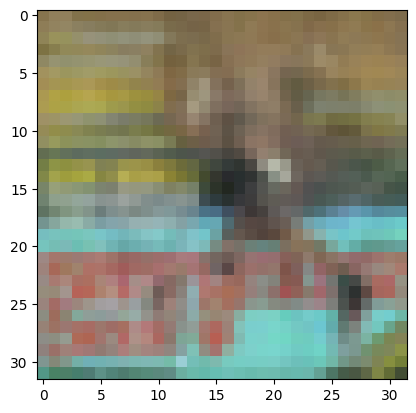

In [15]:
# Fetch a batch of test images
X_test = next(test_batch_generator(batch_size))

# Visualize a few test images with their predicted labels
for i in range(5):
    plt.imshow(X_test[i])
    plt.title(f"Predicted Label: {predicted_labels[i]}")
    plt.axis("off")
    plt.show()
